# Annotating Datasets with Labelbox

All successful computer vision projects start with the same thing: LOTS OF LABELED DATA!

In this walkthrough, we'll cover how to use [the integration](https://voxel51.com/docs/fiftyone/integrations/labelbox.html) between [FiftyOne](https://fiftyone.ai) and the popular annotation tool [Labelbox](https://labelbox.com/) to build a high-quality labeled dataset.

Specifically, this walkthrough covers:

* Using the FiftyOne Brain to select unique samples for annotation
* Annotating unlabeled samples with Labelbox
* Improving existing annotations using FiftyOne tagging and Labelbox
* Additional utilities for managing Labelbox annotation projects

**So, what's the takeaway?**

FiftyOne Datasets are the best way to explore, understand, and improve your datasets and models. This walkthrough covers how to use our Labelbox integration to streamline the annotation creation and improvement process.

## Setup

To get started, you need to [install FiftyOne](https://voxel51.com/docs/fiftyone/getting_started/install.html) and the [Labelbox Python client](https://github.com/Labelbox/labelbox-python):

In [ ]:
!pip install fiftyone labelbox

You'll also need to set up a [Labelbox account](https://app.labelbox.com/). FiftyOne supports both standard Labelbox cloud accounts and Labelbox enterprise solutions.

The easiest way to get started is to use the default Labelbox server, which simply requires creating an account and then providing your API key as shown below.

In [ ]:
!export FIFTYONE_LABELBOX_API_KEY=...

Alternatively, for a more permanent solution, you can store your credentials in your FiftyOne annotation config located at `~/.fiftyone/annotation_config.json`:

In [ ]:
{
    "backends": {
        "labelbox": {
            "api_key": ...,
        }
    }
}

See [this page](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#setup) for more advanced Labelbox setup options.

## Raw Data

To start, you need to gather raw image or video data relevant to your task. The internet has a lot of places to look for free data. Assuming you have your raw data downloaded locally, you can [easily load it into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html).

In [2]:
import fiftyone as fo

In [ ]:
dataset = fo.Dataset.from_dir(dataset_dir="/path/to/dir", dataset_type=fo.types.ImageDirectory)

Another method is to use publicly available datasets that may be relevant. For example, the [Open Images dataset](https://storage.googleapis.com/openimages/web/download.html) contains millions of images available for public use and can be accessed directly through the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html).

In [3]:
import fiftyone.zoo as foz

In [15]:
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    max_samples=100,
    label_types=[],
    dataset_name="labelbox_dataset",
)

Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v6' split 'validation'
 100% |█████████████████| 100/100 [72.9ms elapsed, 0s remaining, 1.4K samples/s]   
Dataset 'labelbox_dataset' created


Either way, once your data is in FiftyOne, we can [visualize it in the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html).


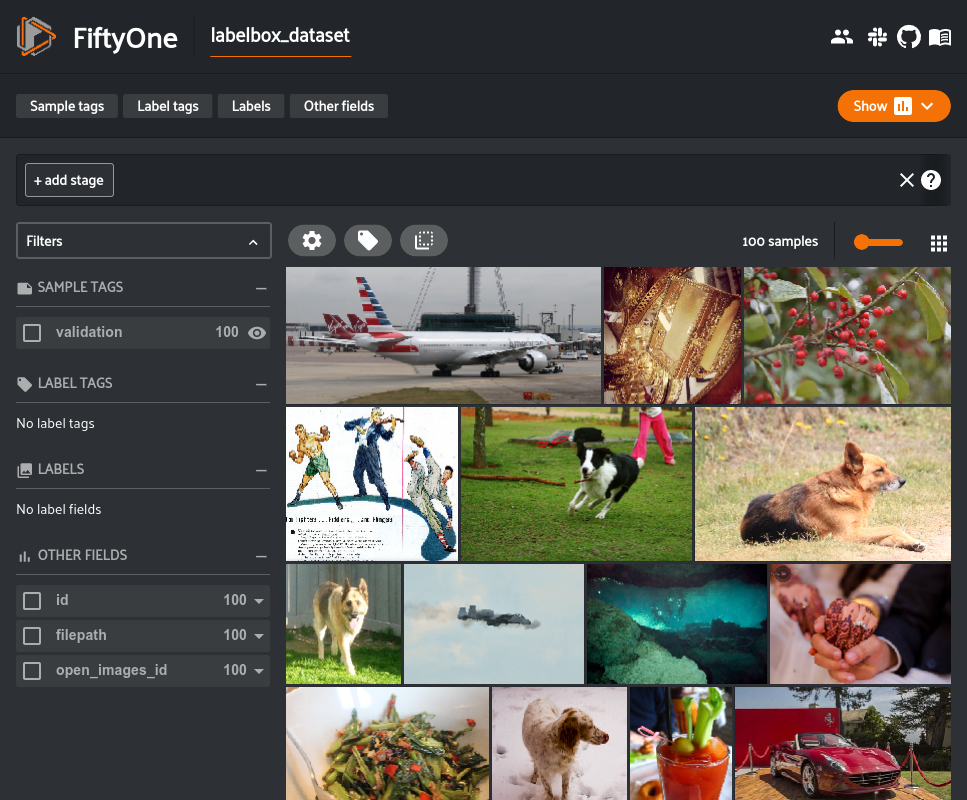

In [18]:
session = fo.launch_app(dataset)

In [23]:
session.freeze() # Screenshot the App in this notebook

FiftyOne provides a [variety of methods](https://voxel51.com/docs/fiftyone/user_guide/brain.html) that can help you understand the quality of the dataset and pick the best samples to annotate. For example, the [`compute_similarity()`](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visual-similarity) the method can be used to find both the most similar, and the most unique samples, ensuring that your dataset will contain an even distribution of data.

In [19]:
import fiftyone.brain as fob

In [20]:
results = fob.compute_similarity(dataset, brain_key="img_sim")

Computing embeddings...
 100% |█████████████████| 100/100 [1.0m elapsed, 0s remaining, 1.8 samples/s]      


In [21]:
results.find_unique(10)

Generating index...
Index complete
Computing unique samples...
threshold: 1.000000, kept: 100, target: 10
threshold: 2.000000, kept: 100, target: 10
threshold: 4.000000, kept: 100, target: 10
threshold: 8.000000, kept: 70, target: 10
threshold: 16.000000, kept: 5, target: 10
threshold: 12.000000, kept: 14, target: 10
threshold: 14.000000, kept: 7, target: 10
threshold: 13.000000, kept: 10, target: 10
Uniqueness computation complete


Now to select only the slice of our dataset that contains the 10 most unique samples.

In [22]:
unique_view = dataset.select(results.unique_ids)


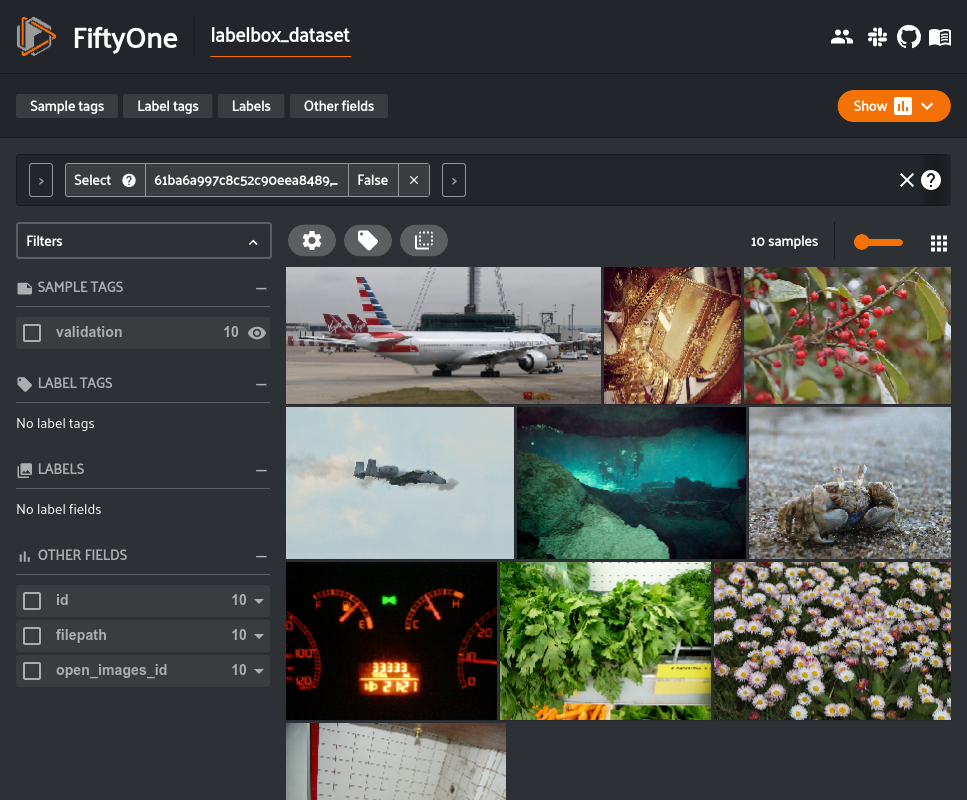

In [24]:
session.view = unique_view

In [25]:
session.freeze()

## Annotation

The [integration between FiftyOne and Labelbox](https://voxel51.com/docs/fiftyone/integrations/labelbox.html) allows you to begin annotating your image or video data by calling a single method!

In [28]:
anno_key = "annotation_run_1"

results = unique_view.annotate(
    anno_key,
    backend="labelbox",
    label_field="detections",
    classes=["vehicle", "animal", "plant"],
    label_type="detections",
    launch_editor=True,
)

Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Uploading samples to Labelbox...
Upload complete
Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Launching editor at 'https://editor.labelbox.com/?project=ckx83uywu09j610a9ertke8ny'...


![labelbox-detection](images/labelbox_detection.webp)

The annotations can then be [loaded back into FiftyOne](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#loading-annotations) in just one more line.

In [30]:
unique_view.load_annotations(anno_key)

Initializing Labelbox client at 'https://api.labelbox.com/graphql'
  133.4Kb [7.2ms elapsed, ? remaining, 91.0Mb/s] 
Download complete
Loading labels for field 'detections'...
 100% |█████████████████████| 8/8 [26.2ms elapsed, 0s remaining, 305.1 samples/s] 



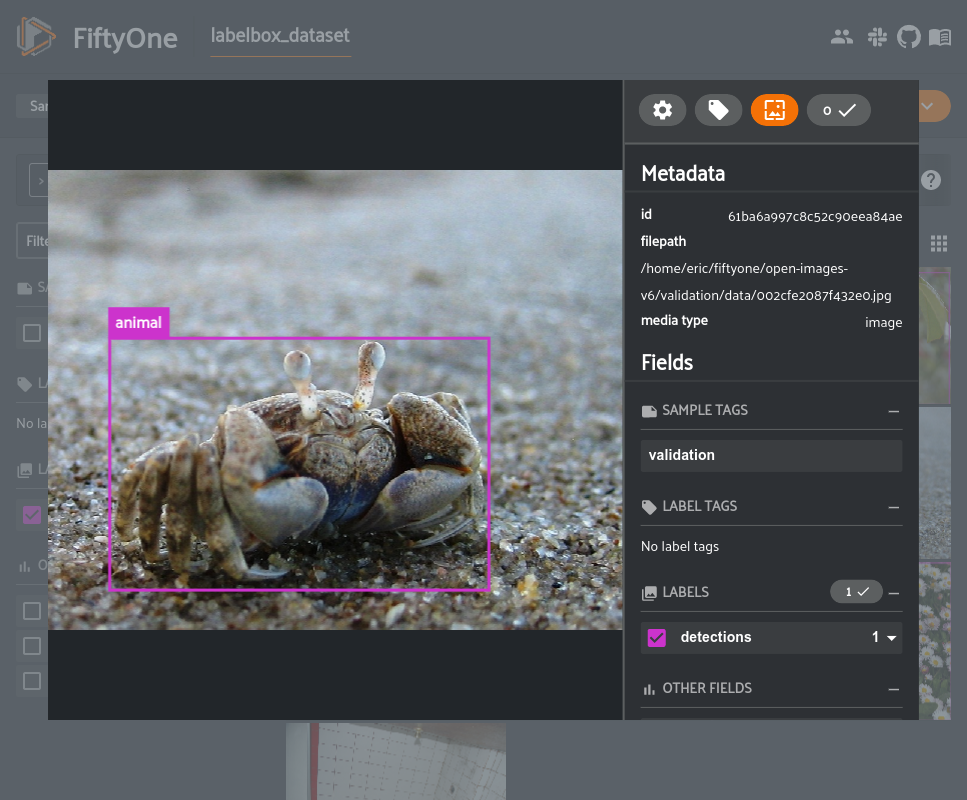

In [31]:
session.view = unique_view

In [32]:
session.freeze()

This API provides [advanced customization options](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#requesting-annotations) for your annotation tasks. For example, we can construct a sophisticated schema to define the annotations we want and even directly assign the annotators:

In [33]:
anno_key = "labelbox_assign_users"

members = [
    ("fiftyone_labelbox_user1@gmail.com", "LABELER"),
    ("fiftyone_labelbox_user2@gmail.com", "REVIEWER"),
    ("fiftyone_labelbox_user3@gmail.com", "TEAM_MANAGER"),
]

# Set up the Labelbox editor to reannotate existing "detections" labels and a new "keypoints" field
label_schema = {
    "detections_new": {
        "type": "detections",
        "classes": dataset.distinct("detections.detections.label"),
    },
    "keypoints": {
        "type": "keypoints",
        "classes": ["Person"],
    }
}

results = unique_view.annotate(
    anno_key,
    backend="labelbox",
    label_schema=label_schema,
    members=members,
    launch_editor=True,
)

Experimental features have been enabled
Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Uploading samples to Labelbox...
Uploading existing labels in field 'detections' to Labelbox is not yet supported
Your organization has reached its limit of 5 members. Cannot invite new member fiftyone_labelbox_user3@gmail.com to project 'FiftyOne_labelbox_dataset'
Upload complete
Experimental features have been enabled
Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Launching editor at 'https://editor.labelbox.com/?project=ckx845cbd0atq10a948ze988n'...


After you're finished annotating in Labelbox, you can easily download the results:

In [35]:
# Download results and clean the run from FiftyOne and Labelbox
unique_view.load_annotations(anno_key, cleanup=True)

Experimental features have been enabled
Initializing Labelbox client at 'https://api.labelbox.com/graphql'
    24.0b [8.4ms elapsed, ? remaining, 58.0Kb/s]   
Download complete
Loading labels for field 'detections'...
 100% |█████████████████████| 0/0 [12.1ms elapsed, ? remaining, ? samples/s] 
Loading labels for field 'keypoints'...
 100% |█████████████████████| 0/0 [1.8ms elapsed, ? remaining, ? samples/s] 
Experimental features have been enabled
Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Deleting project 'ckx845cbd0atq10a948ze988n'...


## Next Steps

Now that you have a labeled dataset, you can go ahead and start training a model. FiftyOne lets you [export your data to disk in a variety of formats](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) (ex: COCO, YOLO, etc) expected by most training pipelines. It also provides workflows for using popular model training libraries like [PyTorch](https://towardsdatascience.com/stop-wasting-time-with-pytorch-datasets-17cac2c22fa8), [PyTorch Lightning Flash](https://voxel51.com/docs/fiftyone/integrations/lightning_flash.html), and [Tensorflow](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html#tfobjectdetectiondataset).

Once the model is trained, the [model predictions can be loaded](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#model-predictions) back into FiftyOne. These [predictions can then be evaluated against the ground truth](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) annotations to find where the model is performing well, and where it is performing poorly. This provides insight into the type of samples that need to be added to the training set, as well as any annotation errors that may exist.

In [36]:
# Load an existing dataset with predictions
dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [37]:
# Evaluate model predictions
dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
)

Evaluating detections...
 100% |█████████████████| 200/200 [6.8s elapsed, 0s remaining, 29.6 samples/s]      


We can use the [powerful querying capabilities of the FiftyOne API](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) to create a [view filtering](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) these model results by false positives with high confidence which generally indicates an error in the ground truth annotation.


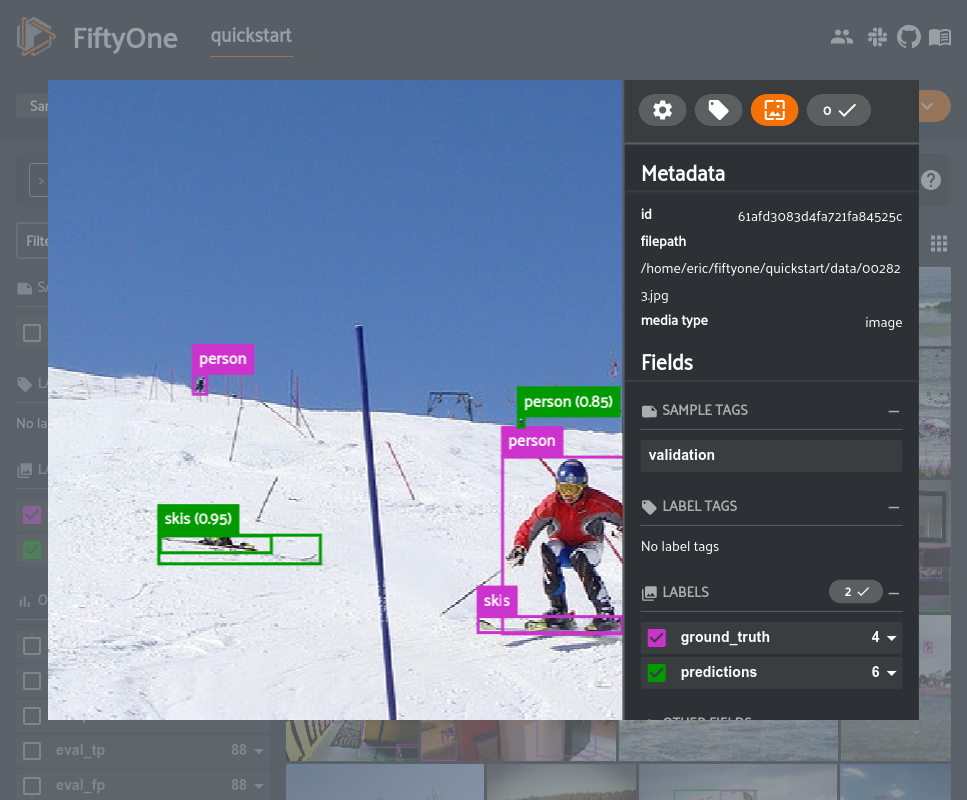

In [39]:
from fiftyone import ViewField as F

fp_view = dataset.filter_labels(
    "predictions",
    (F("confidence") > 0.8) & (F("eval") == "fp"),
)

session = fo.launch_app(view=fp_view)

In [40]:
session.freeze()

This sample appears to be missing a ground truth annotation of skis. Let's [tag it in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), and send it to Labelbox for reannotation.


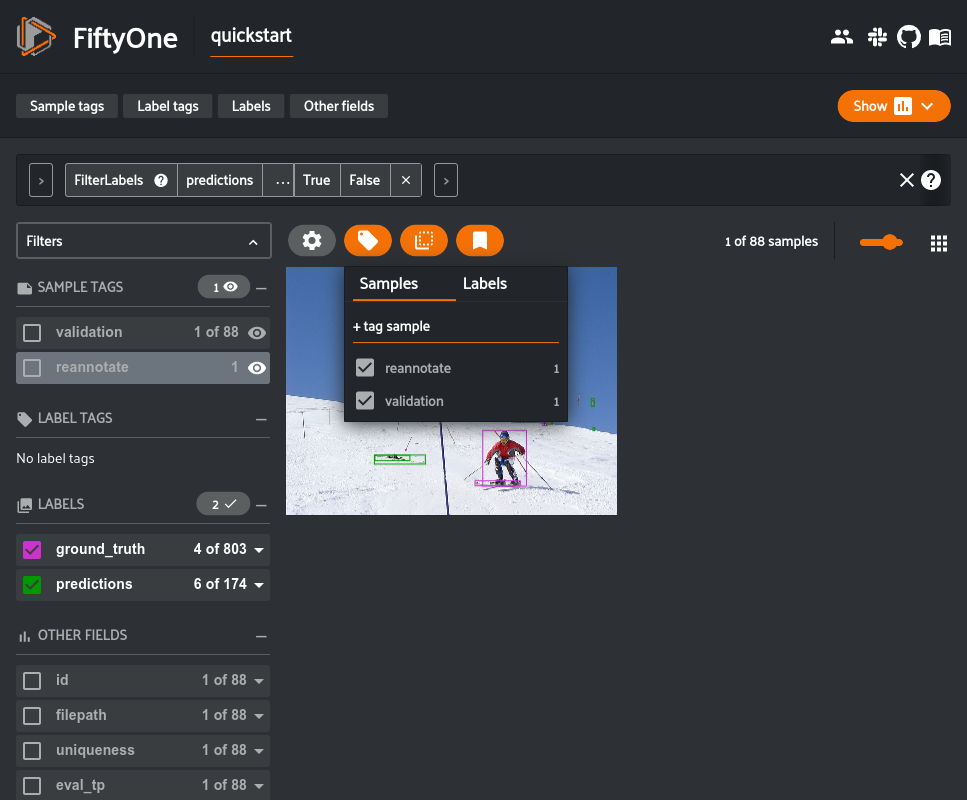

In [41]:
session = fo.launch_app(view=fp_view)

In [42]:
session.freeze()

The workflow for reannotating an existing label field is to annotate a new field, then merge the new field into the existing field.

In [43]:
view = dataset.match_tags("reannotate")

label_schema = {
    "ground_truth_edits": {
        "type": "detections",
        "classes": dataset.distinct("ground_truth.detections.label"),
    }
}

anno_key = "fix_labels"
results = view.annotate(
    anno_key,
    label_schema=label_schema,
    backend="labelbox",
)

Initializing Labelbox client at 'https://api.labelbox.com/graphql'
Uploading samples to Labelbox...
Uploading existing labels in field 'ground_truth' to Labelbox is not yet supported
Upload complete


In [44]:
view.load_annotations(anno_key)

Initializing Labelbox client at 'https://api.labelbox.com/graphql'
   14.6Kb [3.2ms elapsed, ? remaining, 37.7Mb/s]   
Download complete
Loading labels for field 'ground_truth'...
 100% |█████████████████████| 1/1 [18.3ms elapsed, 0s remaining, 54.8 samples/s] 


In [ ]:
view.merge_labels("ground_truth_edits", "ground_truth")


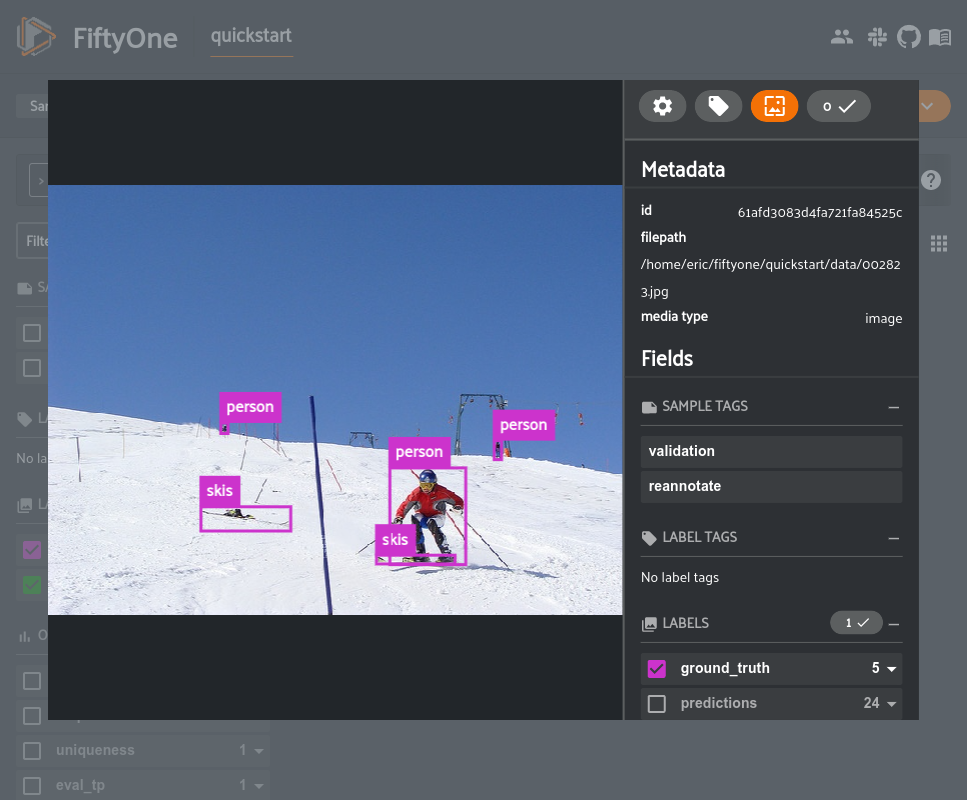

In [45]:
session.view = view

In [46]:
session.freeze()

Iterating over this process of training a model, evaluating its failure modes, and improving the dataset is the most surefire way to produce high-quality datasets and subsequently high-performing models.

## Additional Utilities

You can perform [additional Labelbox-specific operations](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#additional-utilities) to monitor the progress of an annotation project initiated through this integration with FiftyOne.


For example, you can [view the status of an existing project](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#viewing-project-status):

In [47]:
results = dataset.load_annotation_results(anno_key)
results.print_status()

Initializing Labelbox client at 'https://api.labelbox.com/graphql'

Project: FiftyOne_quickstart
ID: ckx84egkf0kx60za90ukgc02a
Created at: 2021-12-15 22:43:41+00:00
Updated at: 2021-12-15 22:43:43+00:00
Number of labeled samples: 1
Members:

	User: Eric Hofesmann
	Name: eric.hofesmann
	Role: Admin
	Email: eric.hofesmann@voxel51.com
	ID: ckl137jfiss1c07320dacd81l


Reviews:
	Positive: 0
	Negative: 0
	Zero: 0


You can also [delete projects](https://voxel51.com/docs/fiftyone/integrations/labelbox.html#deleting-projects) associated with an annotation run directly through the FiftyOne API.

In [ ]:
results = dataset.load_annotation_results(anno_key)
api = results.connect_to_api()

print(results.project_id)
# "bktes8fl60p4s0yba11npdjwm"

api.delete_project(results.project_id, delete_datasets=True)

# OR

api.delete_projects([results.project_id], delete_datasets=True)

# List all projects or datasets associated with your Labelbox account
project_ids = api.list_projects()
dataset_ids = api.list_datasets()

# Delete all projects and datasets from your Labelbox account
api.delete_projects(project_ids_to_delete)
api.delete_datasets(dataset_ids_to_delete)

## Summary

No matter what computer vision projects you are working on, you will need a dataset. [FiftyOne](https://fiftyone.ai) makes it easy to curate and dig into your dataset to understand all aspects of it, including what needs to be annotated or reannotated.

In addition, using our [Labelbox integration](https://voxel51.com/docs/fiftyone/integrations/labelbox.html) can streamline the annotation process and help you build higher quality datasets and models, faster.